In [8]:
import os 
import string 
import matplotlib.pyplot as plt 
import numpy as np
import string 
import torch
import torch.nn as nn 
import os,random,time,math
from tqdm import tqdm

In [9]:
language=[]
data=[]
x=[]
y=[]
file_path='/kaggle/input/rnn-files/rnn.txt'
with open(file_path,'r') as f:
    for line in tqdm(f):
        line=line.split(',')
        name=line[0].strip()
        lang=line[1].strip()
        if not lang in language:
            language.append(lang)
        x.append(name)
        y.append(lang)
        data.append((name,lang))
n_language=len(language)
n_language

20050it [00:00, 476466.13it/s]


18

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [11]:
all_letters=string.ascii_letters+" .,;'"
n_letters=len(all_letters)
n_letters

57

In [12]:
def name_rep(name):
    rep=torch.zeros(len(name),1,n_letters)
    for index,letter in enumerate(name):
        pos=all_letters.find(letter)
        rep[index][0][pos]=1
    return rep

In [13]:
def lang_rep(lang):
    return torch.tensor([language.index(lang)],dtype=torch.long)


In [14]:
count={}
for l in tqdm(language):
    count[l]=0
for d in tqdm(data):
    count[d[1]]+=1

100%|██████████| 20050/20050 [00:00<00:00, 1469949.23it/s]


In [17]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [18]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points
def eval(net, n_points, k, X_, y_):
    
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name)
        val, indices = output.topk(k)
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

In [20]:
def infer(net,name):
    
    net.eval()
    name_ohe=name_rep(name)
    hidden = net.init_hidden()
    for i in range(name_ohe.size()[0]):
        output,hidden=net(name_ohe[i],hidden)
    return output

In [21]:
from IPython.display import clear_output
def train_setup(net,lr=0.01,n_batches=100,batch_size=10,
               momentum=0.9,display_freq=5):
    criterion=nn.NLLLoss()
    opt=torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum)
    
    loss_arr=np.zeros(n_batches+1)
    
    for i in range(n_batches):
        loss_arr[i+1]=(loss_arr[i]*i+train(net,opt,criterion,batch_size))/(i+1)
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

Iteration 99 Top-1: 0.5241895261845386 Top-2: 0.6785536159600998 Loss 1.8103575706481934


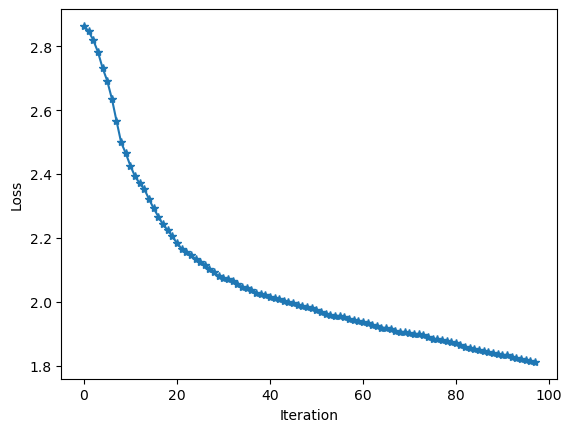

In [22]:
n_hidden = 128
net = LSTM(n_letters, n_hidden, n_language)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)